# Heart failure machine learning classication


### Import libraries

In [1]:
# import libraries
import numpy as np
import pandas as pd
from scipy import stats

# data visualisation libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
import plotly.express as px

# useful data exploration libraries
from pandas_profiling import ProfileReport
import dabl

# ignore warnings
#import warnings
#warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once') # to see warnings once

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, RepeatedStratifiedKFold, KFold, StratifiedKFold, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, auc, precision_recall_curve, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from flaml import AutoML
from flaml.ml import sklearn_metric_loss_score

import time # to track how long the repeat_generations function takes to run

c:\Users\vinhe\anaconda3\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


### Understand the data

In [2]:
# view first 5 rows
df = pd.read_csv('data/heart.csv')

In [3]:
df.head()

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0

In [4]:
df.shape

(918, 12)

In [5]:
# view data types of all columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [6]:
# summary of the numerical features and transpose to make it easier to read
df.describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='RdPu')

In [7]:
# Get quick summary of categorical features
df.select_dtypes(include='object').describe().T

count unique     top freq
Sex              918      2       M  725
ChestPainType    918      4     ASY  496
RestingECG       918      3  Normal  552
ExerciseAngina   918      2       N  547
ST_Slope         918      3    Flat  460

In [8]:
# Look at categorical variables
for colname, coltype in df.dtypes.iteritems():
    if coltype == "object":
        print(colname)
        print(df[colname].unique())

Sex
['M' 'F']
ChestPainType
['ATA' 'NAP' 'ASY' 'TA']
RestingECG
['Normal' 'ST' 'LVH']
ExerciseAngina
['N' 'Y']
ST_Slope
['Up' 'Flat' 'Down']


In [9]:
# find out % of missing values for each column
missing_proportion = df.isnull().sum() / len(df) * 100
print(missing_proportion)

Age               0.0
Sex               0.0
ChestPainType     0.0
RestingBP         0.0
Cholesterol       0.0
FastingBS         0.0
RestingECG        0.0
MaxHR             0.0
ExerciseAngina    0.0
Oldpeak           0.0
ST_Slope          0.0
HeartDisease      0.0
dtype: float64


### Understand the distribution of numerical columns and find potential outliers

Age


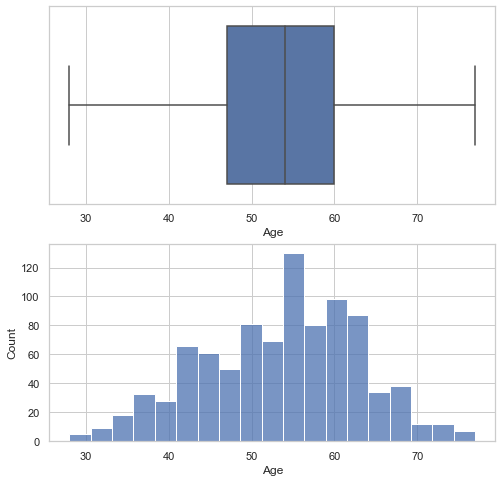

RestingBP


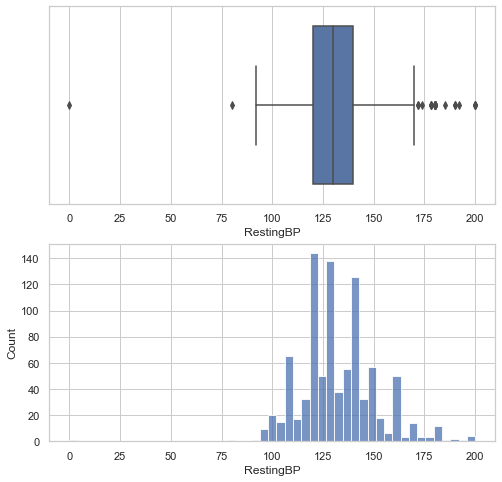

Cholesterol


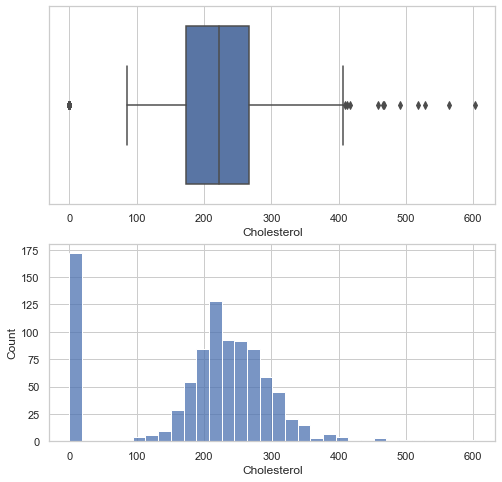

FastingBS


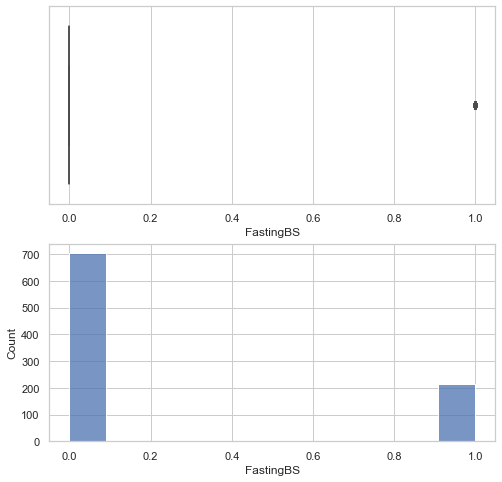

MaxHR


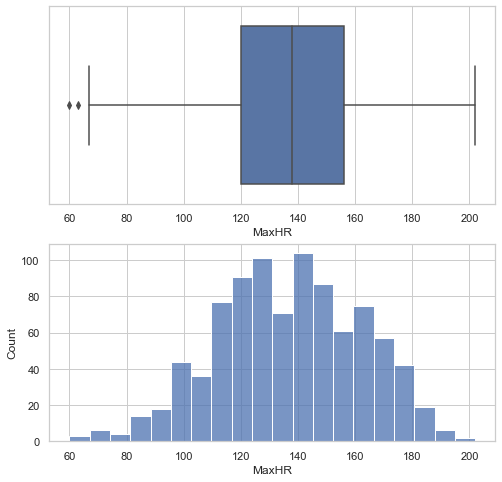

Oldpeak


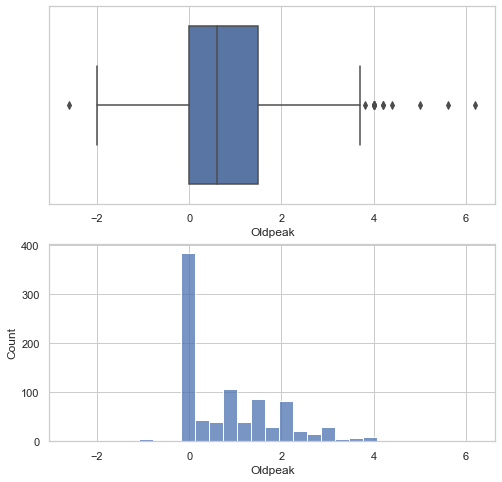

HeartDisease


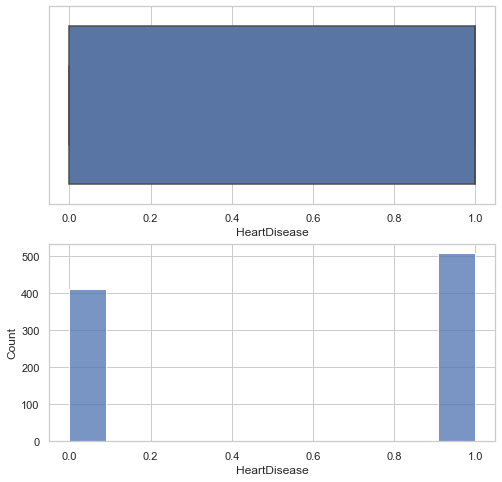

In [10]:
for colname, coltype in df.dtypes.iteritems():
    if (coltype == "float64") or (coltype == "int64"):
        print(colname)
        #fig, ax = plt.subplots(1, 2, figsize=(16,4))
        fig, ax = plt.subplots(2, 1, figsize=(8,8))
        sns.boxplot(data=df, x=colname, ax=ax[0])        
        sns.histplot(data=df, x=colname, ax=ax[1])
        plt.show()

In [11]:
# How unbalanced is the target feature?
heart_diseases  = df.groupby('HeartDisease').count().reset_index().iloc[:,1] / len(df)
print(heart_diseases)
print(f'Target feature skew: {stats.skew(df.HeartDisease)}')

0    0.446623
1    0.553377
Name: Age, dtype: float64
Target feature skew: -0.21473473034684154


In [12]:
# Find out how many records have 0 cholesterol and 0 RestingBP
print(f'There are {len(df[df.Cholesterol == 0])} records with 0 cholesterol. These will be converted to NaN values.')
print(f'There is {len(df[df.RestingBP == 0])} record with 0 RestingBP, this will be removed from the dataset')

df = df[df.RestingBP != 0]

There are 172 records with 0 cholesterol. These will be converted to NaN values.
There is 1 record with 0 RestingBP, this will be removed from the dataset


## Quick EDA

In [13]:
profile = ProfileReport(df)

In [14]:
profile

Render HTML: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


c:\Users\vinhe\anaconda3\lib\site-packages\dabl\plot\supervised.py:546: FutureWarning: The second positional argument of plot is a Series 'y'. If passing a column name, use a keyword.
  warnings.warn("The second positional argument of plot is a Series 'y'."


Target looks like classification
Linear Discriminant Analysis training set score: 0.752


c:\Users\vinhe\anaconda3\lib\site-packages\dabl\plot\utils.py:374: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
c:\Users\vinhe\anaconda3\lib\site-packages\dabl\plot\utils.py:374: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
c:\Users\vinhe\anaconda3\lib\site-packages\dabl\plot\utils.py:374: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
c:\Users\vinhe\anaconda3\lib\site-packages\dabl\plot\utils.py:374: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
c:\Users\vinhe\anaconda3\lib\site-packages\dabl\plot\utils.py:374: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
c:\Users\vinhe\anaconda3\lib\site-packages\dabl\plot\utils.py:374: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


[[<Figure size 1080x1080 with 30 Axes>,
  <Figure size 1152x288 with 4 Axes>,
  <Figure size 432x288 with 1 Axes>],
 None]

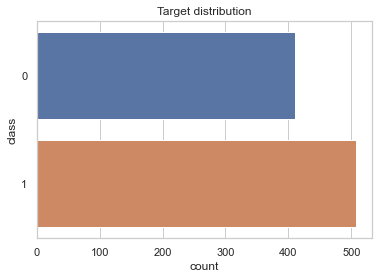

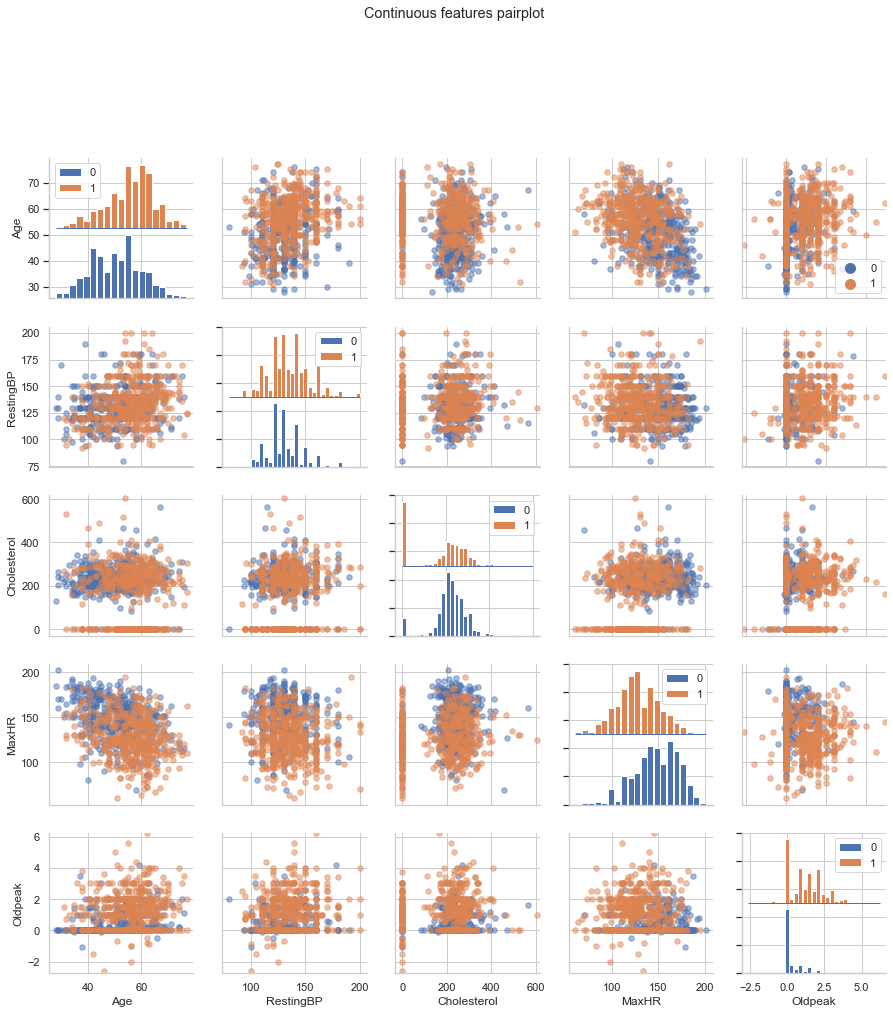

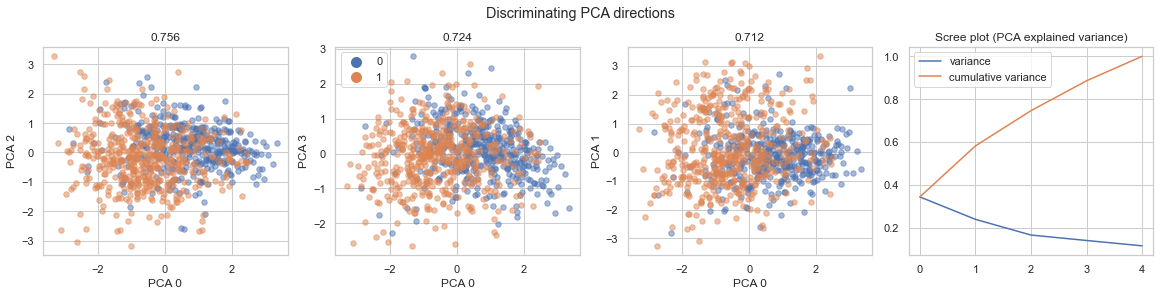

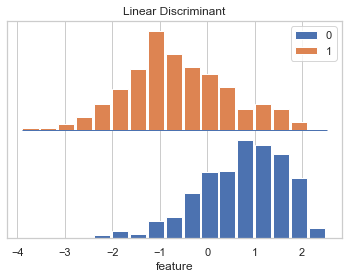

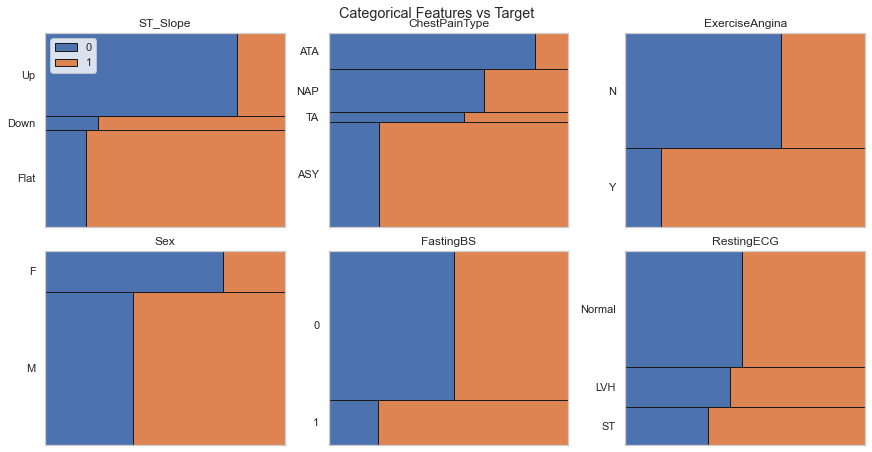

In [15]:
dabl.plot(df, "HeartDisease")

In [16]:
# Get more granular and split by target feature

def hist_and_boxplot(df, column, target):
    fig = px.histogram(df, x=column, color=target,
                       marginal="box")
    fig.update_layout(height=400, width=700, showlegend=True)
    fig.update_traces(marker_line_width=1,marker_line_color="black")
    fig.show()
    
for column in df.columns:
    hist_and_boxplot(df, column, "HeartDisease")

# Set baseline performance

In [17]:
# baseline accuracy, if we assumed every record was positive
base_line_accuracy = np.sum(df.HeartDisease)/df.shape[0]
base_line_accuracy

0.5528898582333697

# Model Building and Training 

### Process data to set benchmark machine learning

In [68]:
def get_dummies(df):
    '''
    Perform One Hot Encoding onto the dataset. Columns were not dropped to improve model explainability. 
    '''
    _cat_cols = df.select_dtypes(include=['object', 'category']).columns.to_list()
    _df_dummies = pd.get_dummies(df, columns=_cat_cols, drop_first=False)
    return _df_dummies

df_ohe = get_dummies(df)
df_ohe.head()

Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  HeartDisease  \
0   40        140          289          0    172      0.0             0   
1   49        160          180          0    156      1.0             1   
2   37        130          283          0     98      0.0             0   
3   48        138          214          0    108      1.5             1   
4   54        150          195          0    122      0.0             0   

   Sex_F  Sex_M  ChestPainType_ASY  ...  ChestPainType_NAP  ChestPainType_TA  \
0      0      1                  0  ...                  0                 0   
1      1      0                  0  ...                  1                 0   
2      0      1                  0  ...                  0                 0   
3      1      0                  1  ...                  0                 0   
4      0      1                  0  ...                  1                 0   

   RestingECG_LVH  RestingECG_Normal  RestingECG_ST  ExerciseAngina_N  \
0               0                  1              0                 1   
1               0                  1              0                 1   
2               0                  0              1                 1   
3               0                  1              0                 0   
4               0                  1              0                 1   

   ExerciseAngina_Y  ST_Slope_Down  ST_Slope_Flat  ST_Slope_Up  
0                 0              0              0            1  
1                 0              0              1            0  
2                 0              0              0            1  
3                 1              0              1            0  
4                 0              0              0            1  

[5 rows x 21 columns]

In [19]:
def split_data(df, _test_size=0.2, _random_state=0):
    '''
    Split dataset into train, test, split
    '''
    X = df.iloc[:, df.columns != 'HeartDisease']
    y = df['HeartDisease']

    # split X and y into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size=_test_size, 
                                                        random_state=_random_state,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(df_ohe)

In [20]:
# Default logistic regression
log_reg = LogisticRegression(solver='lbfgs', max_iter=5000)
# Default random forest
rf = RandomForestClassifier()
# Default XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric ='error')
# Default LightGBM
lgbm = LGBMClassifier()
# Default CatBoost
cat_boost = CatBoostClassifier(logging_level='Silent')

default_models = {
    "Logistic regression": log_reg, 
    "Random forest": rf,
    "XGBoost": xgb, 
    "LightGBM": lgbm, 
    "CatBoost": cat_boost
    }

In [21]:
def evaluate_models_once(X_train, X_test, y_train, y_test, models):
    '''
    Function to evaluate single instances of multiple machine learning models.
    '''
    for key, value in models.items():
        value.fit(X_train, y_train)
        _y_pred = value.predict(X_test)

        _confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, _y_pred),
            columns=["Predicted Survived", "Predicted Died"],
            index=["Survived", "Died"]) 

        _classification = classification_report(y_test, _y_pred)
        print(f"{key}------------------------------")
        print(f"Accuracy = {accuracy_score(y_test, _y_pred)}")
        print(f"Recall = {recall_score(y_test, _y_pred)}")
        print(f"Precision = {precision_score(y_test, _y_pred)}")
        print(f"F1 score = {f1_score(y_test, _y_pred)}")
        print(f"Classification report: \n {_classification}")
        print(f"Confusion matrix: \n {_confusion_matrix_df} \n")

# Evaluate default model performances, using a single run
evaluate_models_once(X_train, X_test, y_train, y_test, models=default_models)

Logistic regression------------------------------
Accuracy = 0.8586956521739131
Recall = 0.8431372549019608
Precision = 0.8958333333333334
F1 score = 0.8686868686868686
Classification report: 
               precision    recall  f1-score   support

           0       0.82      0.88      0.85        82
           1       0.90      0.84      0.87       102

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184

Confusion matrix: 
           Predicted Survived  Predicted Died
Survived                  72              10
Died                      16              86 

Random forest------------------------------
Accuracy = 0.8804347826086957
Recall = 0.8627450980392157
Precision = 0.9166666666666666
F1 score = 0.888888888888889
Classification report: 
               precision    recall  f1-score   support

           0       0.84      0.90      0.87        82
           1       0.92   

In [82]:
def evaluate_models_multiple_times(X_train, X_test, y_train, y_test, models, number_of_runs):
    for key, value in models.items():
        start = time.time()
        accuracy_scores = []
        precision_scores = []
        recall_scores = []
        f1_scores = []

        for _ in range(number_of_runs): 
            value.fit(X_train, y_train)
            _y_pred = value.predict(X_test)
            accuracy_scores.append(accuracy_score(y_test, _y_pred))
            precision_scores.append(precision_score(y_test, _y_pred))
            recall_scores.append(recall_score(y_test, _y_pred))
            f1_scores.append(f1_score(y_test, _y_pred))
        
        print(f"For {number_of_runs} runs of a {key} model:")
        print(f"The mean accuracy was {round(np.mean(accuracy_scores), 3)} ")
        print(f"The mean precision was {round(np.mean(precision_scores), 3)} ")
        print(f"The mean recall was {round(np.mean(recall_scores),3)} ")
        print(f"The mean F1 score was {round(np.mean(f1_scores), 3)} ")
        print(f"This model took {round(time.time() - start, 1)}s to run {number_of_runs} times")
        print("---------------------------------------")

def split_evaluate_models_multiple_times(df, models, number_of_runs):
    for key, value in models.items():
        start = time.time()
        accuracy_scores = []
        precision_scores = []
        recall_scores = []
        f1_scores = []

        for i in range(number_of_runs): 
            X_train, X_test, y_train, y_test = split_data(df, _random_state=i)
            value.fit(X_train, y_train)
            _y_pred = value.predict(X_test)
            accuracy_scores.append(accuracy_score(y_test, _y_pred))
            precision_scores.append(precision_score(y_test, _y_pred))
            recall_scores.append(recall_score(y_test, _y_pred))
            f1_scores.append(f1_score(y_test, _y_pred))
        
        print(f"For {number_of_runs} runs of a {key} model:")
        print(f"The mean accuracy was {round(np.mean(accuracy_scores), 3)} ")
        print(f"The mean precision was {round(np.mean(precision_scores), 3)} ")
        print(f"The mean recall was {round(np.mean(recall_scores),3)} ")
        print(f"The mean F1 score was {round(np.mean(f1_scores), 3)} ")
        print(f"This model took {round(time.time() - start, 1)}s to run {number_of_runs} times")
        print("---------------------------------------")

evaluate_models_multiple_times(
    X_train, 
    X_test, 
    y_train, 
    y_test,
    models=default_models, 
    number_of_runs=10
    )

For 10 runs of a Logistic regression model:
The mean accuracy was 0.853 
The mean precision was 0.895 
The mean recall was 0.833 
The mean F1 score was 0.863 
This model took 0.1s to run 10 times
---------------------------------------
For 10 runs of a Random forest model:
The mean accuracy was 0.854 
The mean precision was 0.88 
The mean recall was 0.853 
The mean F1 score was 0.866 
This model took 1.4s to run 10 times
---------------------------------------
For 10 runs of a XGBoost model:
The mean accuracy was 0.793 
The mean precision was 0.848 
The mean recall was 0.765 
The mean F1 score was 0.804 
This model took 1.0s to run 10 times
---------------------------------------
For 10 runs of a LightGBM model:
The mean accuracy was 0.804 
The mean precision was 0.837 
The mean recall was 0.804 
The mean F1 score was 0.82 
This model took 0.9s to run 10 times
---------------------------------------
For 10 runs of a CatBoost model:
The mean accuracy was 0.87 
The mean precision was 0.8

In [83]:
split_evaluate_models_multiple_times(
    df_ohe,
    models=default_models, 
    number_of_runs=10
    )

For 10 runs of a Logistic regression model:
The mean accuracy was 0.864 
The mean precision was 0.866 
The mean recall was 0.893 
The mean F1 score was 0.879 
This model took 1.0s to run 10 times
---------------------------------------
For 10 runs of a Random forest model:
The mean accuracy was 0.867 
The mean precision was 0.864 
The mean recall was 0.902 
The mean F1 score was 0.883 
This model took 1.5s to run 10 times
---------------------------------------
For 10 runs of a XGBoost model:
The mean accuracy was 0.852 
The mean precision was 0.86 
The mean recall was 0.877 
The mean F1 score was 0.868 
This model took 0.9s to run 10 times
---------------------------------------
For 10 runs of a LightGBM model:
The mean accuracy was 0.858 
The mean precision was 0.866 
The mean recall was 0.881 
The mean F1 score was 0.873 
This model took 0.8s to run 10 times
---------------------------------------
For 10 runs of a CatBoost model:
The mean accuracy was 0.872 
The mean precision was 0

In [23]:
# Split dataset into feature variables and target feature for stratified K-folds evaluation
X = df_ohe.iloc[:, df_ohe.columns != 'HeartDisease']
y = df_ohe['HeartDisease']

In [24]:
def stratified_kfolds_model_eval(X, y, models, _n_splits=5, _n_repeats=10):
    '''
    Apply stratified K-folds to models and evaluate them.
    '''
    # log number of seconds to run function
    start = time.time() 

    # set cross validation
    _cv = RepeatedStratifiedKFold(n_splits=_n_splits, n_repeats=_n_repeats)
    
    # evaluate model
    scoring = ['accuracy', 'precision', 'recall', 'f1']

    for key, value in models.items():
        _start = time.time() 
        scores = cross_validate(estimator=value, X=X, y=y, scoring=scoring, cv=_cv, return_train_score=True)
        print(f"{key} -------------------------------------------")
        print(f"Accuracy: {round(scores.get('test_accuracy').mean(), 4)} (mean) & {round(scores.get('test_accuracy').std(), 4)} (std. dev.)")
        print(f"Precision: {round(scores.get('test_precision').mean(), 4)} (mean) & {round(scores.get('test_precision').std(), 4)} (std. dev.)")
        print(f"Recall: {round(scores.get('test_recall').mean(), 4)} (mean) & {round(scores.get('test_recall').std(), 4)} (std. dev.)")
        print(f"F1 score: {round(scores.get('test_f1').mean(), 4)} (mean) & {round(scores.get('test_f1').std(), 4)} (std. dev.)")
        print(f"This model took {round(time.time() - _start, 1)}s to run")
    end = time.time()
    print(f"This function took {round(end - start, 1)}s to run")

stratified_kfolds_model_eval(X, y, default_models, _n_repeats=10)

Logistic regression -------------------------------------------
Accuracy: 0.8634 (mean) & 0.0253 (std. dev.)
Precision: 0.8653 (mean) & 0.0277 (std. dev.)
Recall: 0.8928 (mean) & 0.0333 (std. dev.)
F1 score: 0.8784 (mean) & 0.0227 (std. dev.)
This model took 6.7s to run
Random forest -------------------------------------------
Accuracy: 0.8711 (mean) & 0.0248 (std. dev.)
Precision: 0.868 (mean) & 0.0255 (std. dev.)
Recall: 0.9051 (mean) & 0.031 (std. dev.)
F1 score: 0.8859 (mean) & 0.0222 (std. dev.)
This model took 8.4s to run
XGBoost -------------------------------------------
Accuracy: 0.858 (mean) & 0.026 (std. dev.)
Precision: 0.8607 (mean) & 0.0307 (std. dev.)
Recall: 0.8879 (mean) & 0.029 (std. dev.)
F1 score: 0.8737 (mean) & 0.0227 (std. dev.)
This model took 6.3s to run
LightGBM -------------------------------------------
Accuracy: 0.8632 (mean) & 0.0198 (std. dev.)
Precision: 0.8667 (mean) & 0.0234 (std. dev.)
Recall: 0.8905 (mean) & 0.0308 (std. dev.)
F1 score: 0.878 (mean) 

In [25]:
def get_logistic_regression_feature_importance(X_train, y_train, model):
    model.fit(X_train, y_train)
    #print(value.coef_)

    _coef = list(model.coef_.flatten())
    feature_importance = pd.DataFrame(
        {"Feature": X_train.columns,
        "Importance": _coef}
        )
    return feature_importance.sort_values(by="Importance", ascending=False)

get_logistic_regression_feature_importance(X_train, y_train, model=log_reg)

Feature  Importance
8   ChestPainType_ASY    1.094824
18      ST_Slope_Flat    1.040641
3           FastingBS    0.954045
7               Sex_M    0.548189
16   ExerciseAngina_Y    0.397143
5             Oldpeak    0.257690
12     RestingECG_LVH    0.212911
0                 Age    0.014475
1           RestingBP    0.009348
2         Cholesterol   -0.004162
4               MaxHR   -0.010432
13  RestingECG_Normal   -0.141751
17      ST_Slope_Down   -0.204806
11   ChestPainType_TA   -0.205303
14      RestingECG_ST   -0.293035
10  ChestPainType_NAP   -0.379617
15   ExerciseAngina_N   -0.619018
9   ChestPainType_ATA   -0.731778
6               Sex_F   -0.770064
19        ST_Slope_Up   -1.057710

In [26]:
tree_models = {
    "Random forest": rf,
    "XGBoost": xgb, 
    "LightGBM": lgbm, 
    "CatBoost": cat_boost
    }

def get_tree_model_feature_importance(X_train, y_train, models):
    for key, value in models.items():
        value.fit(X_train, y_train)
        #print(value.coef_)

        #_coef = list(value.coef_.flatten())
        feature_importance = pd.DataFrame(
            {f"{key} Feature": X_train.columns,
            "Importance": value.feature_importances_}
            )
        
        print(f"{key} ------------------------------")
        print(feature_importance.sort_values(by="Importance", ascending=False))
        
get_tree_model_feature_importance(X_train, y_train, tree_models)

Random forest ------------------------------
   Random forest Feature  Importance
19           ST_Slope_Up    0.117369
4                  MaxHR    0.110927
5                Oldpeak    0.107702
18         ST_Slope_Flat    0.106507
2            Cholesterol    0.093951
8      ChestPainType_ASY    0.076303
0                    Age    0.069317
1              RestingBP    0.067806
15      ExerciseAngina_N    0.048186
16      ExerciseAngina_Y    0.038397
9      ChestPainType_ATA    0.027263
7                  Sex_M    0.026382
6                  Sex_F    0.022344
3              FastingBS    0.021352
10     ChestPainType_NAP    0.014693
12        RestingECG_LVH    0.014211
13     RestingECG_Normal    0.012826
17         ST_Slope_Down    0.009366
14         RestingECG_ST    0.008845
11      ChestPainType_TA    0.006254
XGBoost ------------------------------
      XGBoost Feature  Importance
19        ST_Slope_Up    0.782083
8   ChestPainType_ASY    0.046852
15   ExerciseAngina_N    0.021930
6  

# Now let's rebalance the target feature
Make sure to split data first and then apply sampling methods.
## Try undersampling

In [27]:
def undersample_data(X_train, y_train, random_state=0):
    '''
    Function to apply random undersampling after the dataset has been split into 
    training and test data, to prevent data leakage. Undersampling is a 
    technique to balance the target feature.
    '''
    random_state = random_state
    train_data = pd.concat([X_train, y_train], axis=1)

    # Class count
    count_class_1, count_class_0 = train_data.HeartDisease.value_counts()

    # Divide by class
    df_class_0 = train_data[train_data['HeartDisease'] == 0]
    df_class_1 = train_data[train_data['HeartDisease'] == 1]

    # Undersample 0-class and concat the DataFrames of both class
    df_class_1_under = df_class_1.sample(count_class_0)
    df_test_under = pd.concat([df_class_1_under, df_class_0], axis=0)

    X_train_under = df_test_under.drop('HeartDisease', axis='columns')
    y_train_under = df_test_under['HeartDisease']
    
    return X_train_under, y_train_under


In [28]:
X_train_under, y_train_under = undersample_data(X_train, y_train)

In [29]:
def evaluate_resampled_models_multiple_times(
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    models, 
    number_of_runs,
    sampling_type
    ):
    for key, value in models.items():
        start = time.time()
        accuracy_scores = []
        precision_scores = []
        recall_scores = []
        f1_scores = []

        for _ in range(number_of_runs):
            if sampling_type == 'undersampling':
                X_train, y_train = undersample_data(X_train, y_train, random_state=_)
            elif sampling_type == 'oversampling':
                X_train, y_train = oversample_data(X_train, y_train, random_state=_)
            else:
                X_train, y_train = smote_data(X_train, y_train, random_state=_)

            value.fit(X_train, y_train)
            _y_pred = value.predict(X_test)
            accuracy_scores.append(accuracy_score(y_test, _y_pred))
            precision_scores.append(precision_score(y_test, _y_pred))
            recall_scores.append(recall_score(y_test, _y_pred))
            f1_scores.append(f1_score(y_test, _y_pred))
        
        print(f"For {number_of_runs} runs of a {key} model:")
        print(f"The mean accuracy was {round(np.mean(accuracy_scores), 3)} ")
        print(f"The mean precision was {round(np.mean(precision_scores), 3)} ")
        print(f"The mean recall was {round(np.mean(recall_scores),3)} ")
        print(f"The mean F1 score was {round(np.mean(f1_scores), 3)} ")
        print(f"This model took {round(time.time() - start, 1)}s to run {number_of_runs} times")
        print("---------------------------------------")

In [30]:
# See which default model performs best with random undersampling
evaluate_resampled_models_multiple_times(
    X_train_under, 
    X_test, 
    y_train_under, 
    y_test, 
    models=default_models, 
    number_of_runs=10,
    sampling_type='undersampling'
    )

For 10 runs of a Logistic regression model:
The mean accuracy was 0.853 
The mean precision was 0.912 
The mean recall was 0.814 
The mean F1 score was 0.86 
This model took 1.4s to run 10 times
---------------------------------------
For 10 runs of a Random forest model:
The mean accuracy was 0.867 
The mean precision was 0.914 
The mean recall was 0.84 
The mean F1 score was 0.875 
This model took 2.0s to run 10 times
---------------------------------------
For 10 runs of a XGBoost model:
The mean accuracy was 0.815 
The mean precision was 0.878 
The mean recall was 0.775 
The mean F1 score was 0.823 
This model took 1.1s to run 10 times
---------------------------------------
For 10 runs of a LightGBM model:
The mean accuracy was 0.826 
The mean precision was 0.865 
The mean recall was 0.814 
The mean F1 score was 0.838 
This model took 1.1s to run 10 times
---------------------------------------
For 10 runs of a CatBoost model:
The mean accuracy was 0.891 
The mean precision was 0.

### With undersampling, precision score for minority class 1 improved from XXXX to XXX

### Now try oversampling

In [31]:
def oversample_data(X_train, y_train, random_state=0):
    '''
    Function to apply random oversampling after the dataset has been split into 
    training and test data, to prevent data leakage. Undersampling is a 
    technique to balance the target feature.
    '''
    random_state = random_state
    train_data = pd.concat([X_train, y_train], axis=1)

    # Class count
    count_class_1, count_class_0 = train_data.HeartDisease.value_counts()

    # Divide by class
    df_class_0 = train_data[train_data['HeartDisease'] == 0]
    df_class_1 = train_data[train_data['HeartDisease'] == 1]

    # Oversample 1-class and concat the DataFrames of both classes
    df_class_0_over = df_class_0.sample(count_class_1, replace=True)
    df_test_over = pd.concat([df_class_1, df_class_0_over], axis=0)

    X_train_over = df_test_over.drop('HeartDisease', axis='columns')
    y_train_over = df_test_over['HeartDisease']
    
    return X_train_over, y_train_over   

In [32]:
X_train_over, y_train_over = oversample_data(X_train, y_train)

In [33]:
# See which default model performs best with random oversampling
evaluate_resampled_models_multiple_times(
    X_train_over, 
    X_test, 
    y_train_over, 
    y_test, 
    models=default_models, 
    number_of_runs=10,
    sampling_type = 'oversampling'
    )

For 10 runs of a Logistic regression model:
The mean accuracy was 0.857 
The mean precision was 0.905 
The mean recall was 0.829 
The mean F1 score was 0.865 
This model took 2.3s to run 10 times
---------------------------------------
For 10 runs of a Random forest model:
The mean accuracy was 0.792 
The mean precision was 0.735 
The mean recall was 0.98 
The mean F1 score was 0.84 
This model took 2.3s to run 10 times
---------------------------------------
For 10 runs of a XGBoost model:
The mean accuracy was 0.768 
The mean precision was 0.711 
The mean recall was 0.981 
The mean F1 score was 0.825 
This model took 0.9s to run 10 times
---------------------------------------
For 10 runs of a LightGBM model:
The mean accuracy was 0.718 
The mean precision was 0.665 
The mean recall was 0.99 
The mean F1 score was 0.796 
This model took 0.9s to run 10 times
---------------------------------------
For 10 runs of a CatBoost model:
The mean accuracy was 0.771 
The mean precision was 0.7

### With oversampling, precision score for minority class 1 improved from 0.41 to 0.94

## Try SMOTE

In [34]:
def smote_data(X_train, y_train, random_state=0):
    smote = SMOTE(sampling_strategy='minority', random_state=random_state)

    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    return X_train_smote, y_train_smote

In [35]:
X_train_smote, y_train_smote = smote_data(X_train, y_train)

In [36]:
# See which default model performs best with SMOTE oversampling
evaluate_resampled_models_multiple_times(
    X_train_smote, 
    X_test, 
    y_train_smote, 
    y_test, 
    models=default_models, 
    number_of_runs=10,
    sampling_type = 'smote'
    )

For 10 runs of a Logistic regression model:
The mean accuracy was 0.859 
The mean precision was 0.904 
The mean recall was 0.833 
The mean F1 score was 0.867 
This model took 3.3s to run 10 times
---------------------------------------
For 10 runs of a Random forest model:
The mean accuracy was 0.868 
The mean precision was 0.913 
The mean recall was 0.843 
The mean F1 score was 0.877 
This model took 1.9s to run 10 times
---------------------------------------
For 10 runs of a XGBoost model:
The mean accuracy was 0.815 
The mean precision was 0.878 
The mean recall was 0.775 
The mean F1 score was 0.823 
This model took 1.3s to run 10 times
---------------------------------------
For 10 runs of a LightGBM model:
The mean accuracy was 0.832 
The mean precision was 0.874 
The mean recall was 0.814 
The mean F1 score was 0.843 
This model took 1.2s to run 10 times
---------------------------------------
For 10 runs of a CatBoost model:
The mean accuracy was 0.875 
The mean precision was 

# Feature engineering: bin numerical features

In [54]:
def bin_numerical_features(split_df):
    numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR']
    for col in numerical_cols:
        split_df[f'{col}_binned'] = pd.qcut(split_df[col], 5, labels=['1', '2', '3', '4', '5'])
    split_df.drop(columns=numerical_cols, inplace=True)
    for col in numerical_cols:
        split_df[f'{col}_binned'] = split_df[f'{col}_binned'].astype(str)
        split_df[f'{col}_binned'] = split_df[f'{col}_binned'].str.replace(',', '-', regex=True)
    for col in numerical_cols:   
        split_df[f'{col}_binned'] = split_df[f'{col}_binned'].str.replace(']', '', regex=True)
    split_df_binned_ohe = get_dummies(split_df)    
    
    return split_df_binned_ohe

In [61]:
X_train, X_test, y_train, y_test = split_data(df_ohe)

evaluate_models_multiple_times(
    bin_numerical_features(X_train), 
    bin_numerical_features(X_test), 
    y_train, 
    y_test,
    models=default_models, 
    number_of_runs=10
    )

For 10 runs of a Logistic regression model:
The mean accuracy was 0.891 
The mean precision was 0.927 
The mean recall was 0.873 
The mean F1 score was 0.899 
This model took 0.2s to run 10 times
---------------------------------------
For 10 runs of a Random forest model:
The mean accuracy was 0.873 
The mean precision was 0.897 
The mean recall was 0.872 
The mean F1 score was 0.884 
This model took 2.7s to run 10 times
---------------------------------------
For 10 runs of a XGBoost model:
The mean accuracy was 0.842 
The mean precision was 0.876 
The mean recall was 0.833 
The mean F1 score was 0.854 
This model took 1.7s to run 10 times
---------------------------------------
For 10 runs of a LightGBM model:
The mean accuracy was 0.859 
The mean precision was 0.888 
The mean recall was 0.853 
The mean F1 score was 0.87 
This model took 0.9s to run 10 times
---------------------------------------
For 10 runs of a CatBoost model:
The mean accuracy was 0.875 
The mean precision was 0

# Feature engineering: scale the data

In [65]:
numerical_cols_oldpeak = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()
max_abs_scaler = MaxAbsScaler()

## Test standard scaling

In [62]:
def scale_split_df(split_df, scaler):
    split_df[numerical_cols_oldpeak] = scaler.fit_transform(split_df[numerical_cols_oldpeak])
    return split_df

In [71]:
X_train, X_test, y_train, y_test = split_data(df_ohe)

In [76]:
evaluate_models_multiple_times(
    scale_split_df(X_train, standard_scaler),
    scale_split_df(X_test, standard_scaler), 
    y_train, 
    y_test,
    models=default_models, 
    number_of_runs=10
    )

For 10 runs of a Logistic regression model:
The mean accuracy was 0.859 
The mean precision was 0.896 
The mean recall was 0.843 
The mean F1 score was 0.869 
This model took 0.2s to run 10 times
---------------------------------------
For 10 runs of a Random forest model:
The mean accuracy was 0.862 
The mean precision was 0.896 
The mean recall was 0.851 
The mean F1 score was 0.873 
This model took 1.9s to run 10 times
---------------------------------------
For 10 runs of a XGBoost model:
The mean accuracy was 0.804 
The mean precision was 0.884 
The mean recall was 0.745 
The mean F1 score was 0.809 
This model took 1.2s to run 10 times
---------------------------------------
For 10 runs of a LightGBM model:
The mean accuracy was 0.842 
The mean precision was 0.901 
The mean recall was 0.804 
The mean F1 score was 0.85 
This model took 1.1s to run 10 times
---------------------------------------
For 10 runs of a CatBoost model:
The mean accuracy was 0.875 
The mean precision was 0

### Test min-max scaler

In [77]:
evaluate_models_multiple_times(
    scale_split_df(X_train, min_max_scaler),
    scale_split_df(X_test, min_max_scaler), 
    y_train, 
    y_test,
    models=default_models, 
    number_of_runs=10
    )

For 10 runs of a Logistic regression model:
The mean accuracy was 0.853 
The mean precision was 0.895 
The mean recall was 0.833 
The mean F1 score was 0.863 
This model took 0.2s to run 10 times
---------------------------------------
For 10 runs of a Random forest model:
The mean accuracy was 0.853 
The mean precision was 0.885 
The mean recall was 0.845 
The mean F1 score was 0.865 
This model took 2.9s to run 10 times
---------------------------------------
For 10 runs of a XGBoost model:
The mean accuracy was 0.793 
The mean precision was 0.848 
The mean recall was 0.765 
The mean F1 score was 0.804 
This model took 1.8s to run 10 times
---------------------------------------
For 10 runs of a LightGBM model:
The mean accuracy was 0.804 
The mean precision was 0.837 
The mean recall was 0.804 
The mean F1 score was 0.82 
This model took 1.0s to run 10 times
---------------------------------------
For 10 runs of a CatBoost model:
The mean accuracy was 0.87 
The mean precision was 0.

### Test abolsolute maximum scaler

In [78]:
evaluate_models_multiple_times(
    scale_split_df(X_train, max_abs_scaler),
    scale_split_df(X_test, max_abs_scaler), 
    y_train, 
    y_test,
    models=default_models, 
    number_of_runs=10
    )

For 10 runs of a Logistic regression model:
The mean accuracy was 0.853 
The mean precision was 0.895 
The mean recall was 0.833 
The mean F1 score was 0.863 
This model took 0.3s to run 10 times
---------------------------------------
For 10 runs of a Random forest model:
The mean accuracy was 0.858 
The mean precision was 0.885 
The mean recall was 0.855 
The mean F1 score was 0.87 
This model took 2.8s to run 10 times
---------------------------------------
For 10 runs of a XGBoost model:
The mean accuracy was 0.793 
The mean precision was 0.848 
The mean recall was 0.765 
The mean F1 score was 0.804 
This model took 1.4s to run 10 times
---------------------------------------
For 10 runs of a LightGBM model:
The mean accuracy was 0.804 
The mean precision was 0.837 
The mean recall was 0.804 
The mean F1 score was 0.82 
This model took 1.2s to run 10 times
---------------------------------------
For 10 runs of a CatBoost model:
The mean accuracy was 0.87 
The mean precision was 0.8

# FLAML to automate hyperparameter tuning

In [50]:
automl = AutoML()

settings = {
    "time_budget": 180,  # total running time in seconds
    "metric": 'accuracy',
    "task": 'classification',
    "verbose": 2,
    "estimator_list": ["rf", "xgboost", "lgbm", "catboost"],
    "log_file_name": 'heart_failure_logger.log',  # flaml log file
    "eval_method": "cv",
    "n_splits": 5,
    "seed": 1,    # random seed
}

In [51]:
automl.fit(X_train, y_train, **settings)

In [52]:
'''retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparameter:', automl.best_result)
print('Best hyperparmeter config:', automl.best_config)
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: rf
Best hyperparameter: {'pred_time': 0.00011312226615495533, 'wall_clock_time': 73.62655258178711, 'metric_for_logging': None, 'val_loss': 0.11441617742987609, 'training_iteration': 1, 'config': {'n_estimators': 61, 'max_features': 0.10997580644981278, 'max_leaves': 24, 'criterion': 'entropy'}, 'config/n_estimators': 61, 'config/max_features': 0.10997580644981278, 'config/max_leaves': 24, 'config/criterion': 'entropy', 'experiment_tag': 'exp', 'time_total_s': 0.51426100730896}
Best hyperparmeter config: {'n_estimators': 61, 'max_features': 0.10997580644981278, 'max_leaves': 24, 'criterion': 'entropy'}
Training duration of best run: 0.116 s


In [53]:
automl.best_config_per_estimator

{'rf': {'n_estimators': 61,
  'max_features': 0.10997580644981278,
  'max_leaves': 24,
  'criterion': 'entropy'},
 'xgboost': {'n_estimators': 21,
  'max_leaves': 39,
  'min_child_weight': 0.6144701168696796,
  'learning_rate': 0.6025065688982266,
  'subsample': 0.8645187247261322,
  'colsample_bylevel': 0.5806606307676404,
  'colsample_bytree': 0.9723660718192093,
  'reg_alpha': 0.00582653000292083,
  'reg_lambda': 0.22608359102543715},
 'lgbm': {'n_estimators': 16,
  'num_leaves': 7,
  'min_child_samples': 3,
  'learning_rate': 0.24056789294162587,
  'log_max_bin': 5,
  'colsample_bytree': 0.8589366088312348,
  'reg_alpha': 0.0770560749742843,
  'reg_lambda': 0.005203677732231893},
 'catboost': {'early_stopping_rounds': 24,
  'learning_rate': 0.12274698638715617,
  'n_estimators': 16}}

In [54]:
print("FLAML:")
for key, value in automl.best_loss_per_estimator.items():
    print(f"{key} best accuracy: {1 - value}")

FLAML:
rf best accuracy: 0.8855838225701239
xgboost best accuracy: 0.8692293355698444
lgbm best accuracy: 0.8719690615972416
catboost best accuracy: 0.8842046407604137


In [55]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(X_test)

''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score
print('accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))
print(f"Accuracy = {accuracy_score(y_test, y_pred)}")
print(f"Recall = {recall_score(y_test, y_pred)}")
print(f"Precision = {precision_score(y_test, y_pred)}")
print(f"F1 score = {f1_score(y_test, y_pred)}")

accuracy = 0.8858695652173914
Accuracy = 0.8858695652173914
Recall = 0.8921568627450981
Precision = 0.900990099009901
F1 score = 0.8965517241379312


In [56]:
settings1 = {
    "time_budget": 600,  # total running time in seconds
    "metric": 'accuracy',
    "task": 'classification',
    "verbose": 2,
    "estimator_list": ["rf", "xgboost", "lgbm", "catboost"],
    "log_file_name": 'heart_failure_logger.log',  # flaml log file
    "eval_method": "cv",
    "n_splits": 5,
    "seed": 1,    # random seed
}

automl.fit(X_train, y_train, **settings1)

In [57]:
'''retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparameter:', automl.best_result)
print('Best hyperparmeter config:', automl.best_config)
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: catboost
Best hyperparameter: {'pred_time': 1.771569796348816e-05, 'wall_clock_time': 46.739304542541504, 'metric_for_logging': None, 'val_loss': 0.11579535923958625, 'training_iteration': 1, 'config': {'early_stopping_rounds': 24, 'learning_rate': 0.12274698638715617, 'n_estimators': 16}, 'config/early_stopping_rounds': 24, 'config/learning_rate': 0.12274698638715617, 'config/n_estimators': 8192, 'experiment_tag': 'exp', 'time_total_s': 0.5897214412689209}
Best hyperparmeter config: {'early_stopping_rounds': 24, 'learning_rate': 0.12274698638715617, 'n_estimators': 16}
Training duration of best run: 0.1206 s


In [58]:
automl.best_config_per_estimator

{'rf': {'n_estimators': 10,
  'max_features': 0.1774385136633067,
  'max_leaves': 7,
  'criterion': 'entropy'},
 'xgboost': {'n_estimators': 14,
  'max_leaves': 33,
  'min_child_weight': 0.07806954467963993,
  'learning_rate': 1.0,
  'subsample': 0.9907462680788609,
  'colsample_bylevel': 0.540327604353237,
  'colsample_bytree': 0.8770961177139903,
  'reg_alpha': 0.0028811060030028432,
  'reg_lambda': 0.08240429523802545},
 'lgbm': {'n_estimators': 306,
  'num_leaves': 4,
  'min_child_samples': 2,
  'learning_rate': 0.020226500725724808,
  'log_max_bin': 4,
  'colsample_bytree': 1.0,
  'reg_alpha': 0.0503940887294782,
  'reg_lambda': 0.08474347927915671},
 'catboost': {'early_stopping_rounds': 24,
  'learning_rate': 0.12274698638715617,
  'n_estimators': 16}}

In [59]:
print("FLAML:")
for key, value in automl.best_loss_per_estimator.items():
    print(f"{key} best accuracy: {1 - value}")

FLAML:
rf best accuracy: 0.852893486161588
xgboost best accuracy: 0.8705805609915199
lgbm best accuracy: 0.87741123846799
catboost best accuracy: 0.8842046407604137


In [60]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(X_test)

''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score
print('accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))
print(f"Accuracy = {accuracy_score(y_test, y_pred)}")
print(f"Recall = {recall_score(y_test, y_pred)}")
print(f"Precision = {precision_score(y_test, y_pred)}")
print(f"F1 score = {f1_score(y_test, y_pred)}")

accuracy = 0.8641304347826086
Accuracy = 0.8641304347826086
Recall = 0.8529411764705882
Precision = 0.8969072164948454
F1 score = 0.8743718592964823


# Random Forest


In [61]:
# checking the oob score
#print(rf_model.oob_score_)
print('Best hyperparmeter config:', automl.best_config)

Best hyperparmeter config: {'early_stopping_rounds': 24, 'learning_rate': 0.12274698638715617, 'n_estimators': 16}


In [62]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1)

params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [20, 30, 40, 50],
    'n_estimators': [320, 340, 360, 380],
    'max_features': [0.05, 0.1, 0.15, 0.2]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, 
                           verbose=2, 
                           scoring="accuracy"
                           )

In [63]:
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 320 candidates, totalling 1280 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'max_features': [0.05, 0.1, 0.15, 0.2],
                         'min_samples_leaf': [20, 30, 40, 50],
                         'n_estimators': [320, 340, 360, 380]},
             scoring='accuracy', verbose=2)

In [64]:
print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

0.8610640888572108
{'max_depth': 3, 'max_features': 0.1, 'min_samples_leaf': 30, 'n_estimators': 320}
RandomForestClassifier(max_depth=3, max_features=0.1, min_samples_leaf=30,
                       n_estimators=320, n_jobs=-1, random_state=0)


In [65]:
print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

0.8610640888572108
{'max_depth': 3, 'max_features': 0.1, 'min_samples_leaf': 30, 'n_estimators': 320}
RandomForestClassifier(max_depth=3, max_features=0.1, min_samples_leaf=30,
                       n_estimators=320, n_jobs=-1, random_state=0)


In [66]:
rf_grid = grid_search.best_estimator_
rf_grid.score(X_train, y_train)


0.8732970027247956

In [67]:
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred, labels=rf_grid.classes_))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86        82
           1       0.90      0.87      0.89       102

    accuracy                           0.88       184
   macro avg       0.87      0.88      0.87       184
weighted avg       0.88      0.88      0.88       184



In [68]:
print(confusion_matrix(y_test, y_pred))

[[72 10]
 [13 89]]


c:\Users\vinhe\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



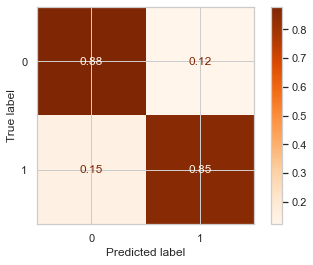

In [69]:
plot_confusion_matrix(automl.model, X_test, y_test, cmap='Oranges', normalize='true')